# Assignment 11

#### 1. Import all libraries

In [1]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

print('Imported all libraries!')

[nltk_data] Downloading package stopwords to C:\Users\AINS-
[nltk_data]     SENGLY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\AINS-
[nltk_data]     SENGLY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Imported all libraries!


#### 2. Read data

In [2]:
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print("Finished Read Files!")


Finished Read Files!


In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
print('Defined sigmoid function!')

Defined sigmoid function!


#### 3. Training model

In [4]:
col_train_j = []
col_test_j = []
col_train_acc = []
col_test_acc = []

num_iter = 100
num_train = 1400
num_test = 600

iput_len = 1500
lay1_len = 150
lay2_len = 15
oput_len = 2

u = np.random.normal(0,1,[iput_len+1,lay1_len])
v = np.random.normal(0,1,[lay1_len+1,lay2_len])
w = np.random.normal(0,1,[lay2_len+1,oput_len])

for iteration in range(num_iter):
    
    sum_train_j = 0
    sum_test_j = 0
    sum_train_acc = 0
    sum_test_acc = 0
    
    ################# Training ###################    
    for itrain in range(num_train):
    
        input_v = np.append(X_train[itrain],1)
        input_v = np.reshape(input_v, (-1, iput_len+1))
        
        actual_l = np.zeros(oput_len)
        actual_l[Y_train[itrain]] = 1
        
        y_ = input_v.dot(u)
        y = sigmoid(y_)
        y = np.reshape(np.append(y, 1), (-1, len(np.append(y,1))))
        
        z_ = y.dot(v)
        z = sigmoid(z_)
        z = np.reshape(np.append(z, 1), (-1, len(np.append(z,1))))

        h_ = z.dot(w)
        h = sigmoid(h_)
        
        dl_dh = -actual_l/h + (1.0 - actual_l)/(1.0 - h)
        dl_dh = np.reshape(dl_dh,(-1,oput_len))

        dh_dhh = sigmoid(h_)*(1 - sigmoid(h_))
        dh_dhh = np.reshape(dh_dhh,(-1,oput_len))

        sigma = dl_dh*dh_dhh
        sigma = np.reshape(sigma,(oput_len,-1))
        
        dl_dw = sigma.dot(z)
        dl_dw = np.transpose(dl_dw)

        w = w - 0.01*dl_dw
        
        ##############################################
        
        sigma_s = w.dot(sigma)  
        sigma_s = sigma_s[:-1]

        dz_dzz = sigmoid(z_)*(1 - sigmoid(z_))
        dz_dzz = np.reshape(dz_dzz,(lay2_len,-1))

        sigma_s_x_dz_dzz = sigma_s*dz_dzz

        dl_dv = sigma_s_x_dz_dzz.dot(y)
        dl_dv = np.transpose(dl_dv)

        v = v - 0.01*dl_dv
        
        ###############################################
        sigma_s1 = v.dot(sigma_s)
        sigma_s1 = sigma_s1[:-1]

        dy_dyy = sigmoid(y_)*(1 - sigmoid(y_))
        dy_dyy = np.reshape(dy_dyy,(lay1_len,-1))

        bb = sigma_s1*dy_dyy

        dl_du = bb.dot(input_v)
        dl_du = np.transpose(dl_du)

        u = u - 0.01*dl_du
        
        sum_train_j += np.sum( -actual_l * np.log(h) - (1 - actual_l) * np.log(1 - h))

        output_l = np.zeros(oput_len)
        output_l[np.argmax(h)] = 1

        dE_dh = actual_l - output_l

        if np.sum(dE_dh**2) == 0:
            sum_train_acc += 1
    ################# Training ###################
    
    ################# Testing ###################    
    for itest in range(num_test):

        input_v = np.append(X_test[itest],1)
        input_v = np.reshape(input_v, (-1, len(input_v)))

        actual_l = np.zeros(oput_len)
        actual_l[Y_test[itest]] = 1

        y_ = input_v.dot(u)
        y = sigmoid(y_)
        y = np.reshape(np.append(y, 1), (-1, len(np.append(y,1))))

        z_ = y.dot(v)
        z = sigmoid(z_)
        z = np.reshape(np.append(z, 1), (-1, len(np.append(z,1))))

        h_ = z.dot(w)
        h = sigmoid(h_) 

        sum_test_j += np.sum( -actual_l * np.log(h) - (1 - actual_l) * np.log(1 - h))
        output_l = np.zeros(oput_len)
        output_l[np.argmax(h)] = 1

        dE_dh = actual_l - output_l
        if np.sum(dE_dh**2) == 0:
            sum_test_acc += 1
    ################# Testing ###################
    
    ############# Validation ################
    rand_int = np.random.randint(400)
    
    input_v = np.append(X_test[rand_int],1)
    input_v = np.reshape(input_v, (-1, iput_len+1))
    
    actual_l = np.zeros(oput_len)
    actual_l[Y_test[rand_int]] = 1
    
    y_ = input_v.dot(u)
    y = sigmoid(y_)
    y = np.reshape(np.append(y, 1), (-1, len(np.append(y,1))))
    
    z_ = y.dot(v)
    z = sigmoid(z_)
    z = np.reshape(np.append(z, 1), (-1, len(np.append(z,1))))
    
    h_ = z.dot(w)
    h = sigmoid(h_)
    
    dl_dh = -actual_l/h + (1.0 - actual_l)/(1.0 - h)
    dl_dh = np.reshape(dl_dh,(-1,oput_len))
    
    dh_dhh = sigmoid(h_)*(1 - sigmoid(h_))
    dh_dhh = np.reshape(dh_dhh,(-1,oput_len))
    
    sigma = dl_dh*dh_dhh
    sigma = np.reshape(sigma,(oput_len,-1))
    
    dl_dw = sigma.dot(z)
    dl_dw = np.transpose(dl_dw)
    
    w = w - 0.01*dl_dw
    
    ##############################################
    
    sigma_s = w.dot(sigma)  
    sigma_s = sigma_s[:-1]
    
    dz_dzz = sigmoid(z_)*(1 - sigmoid(z_))
    dz_dzz = np.reshape(dz_dzz,(lay2_len,-1))
    
    sigma_s_x_dz_dzz = sigma_s*dz_dzz
    
    dl_dv = sigma_s_x_dz_dzz.dot(y)
    dl_dv = np.transpose(dl_dv)
    
    v = v - 0.01*dl_dv
    
    ###############################################
    sigma_s1 = v.dot(sigma_s)
    sigma_s1 = sigma_s1[:-1]
    
    dy_dyy = sigmoid(y_)*(1 - sigmoid(y_))
    dy_dyy = np.reshape(dy_dyy,(lay1_len,-1))
    
    bb = sigma_s1*dy_dyy
    
    dl_du = bb.dot(input_v)
    dl_du = np.transpose(dl_du)
    
    u = u - 0.01*dl_du 
    ################### Valudation ############################
           
    col_train_j.append(sum_train_j/num_train)
    col_test_j.append(sum_test_j/num_test)
    col_train_acc.append(sum_train_acc/num_train)
    col_test_acc.append(sum_test_acc/num_test)
    
    if np.mod(iteration+1,10) == 0:
    
        print('iteration: %2d , Train Error: %.4f, Train Acc: %.4f' % (iteration+1,sum_train_j/num_train,sum_train_acc/num_train))
        print('              , Test  Error: %.4f, Test  Acc: %.4f' % (sum_test_j/num_test,sum_test_acc/num_test))
        
print('Network trained!')

iteration: 10 , Train Error: 0.5722, Train Acc: 0.8914
              , Test  Error: 0.9468, Test  Acc: 0.7733
iteration: 20 , Train Error: 0.1232, Train Acc: 0.9921
              , Test  Error: 0.7397, Test  Acc: 0.8717
iteration: 30 , Train Error: 0.0389, Train Acc: 1.0000
              , Test  Error: 0.6654, Test  Acc: 0.8867
iteration: 40 , Train Error: 0.0211, Train Acc: 1.0000
              , Test  Error: 0.5918, Test  Acc: 0.9133
iteration: 50 , Train Error: 0.0135, Train Acc: 1.0000
              , Test  Error: 0.5277, Test  Acc: 0.9250
iteration: 60 , Train Error: 0.0094, Train Acc: 1.0000
              , Test  Error: 0.5322, Test  Acc: 0.9317
iteration: 70 , Train Error: 0.0070, Train Acc: 1.0000
              , Test  Error: 0.5452, Test  Acc: 0.9317
iteration: 80 , Train Error: 0.0055, Train Acc: 1.0000
              , Test  Error: 0.5503, Test  Acc: 0.9350
iteration: 90 , Train Error: 0.0044, Train Acc: 1.0000
              , Test  Error: 0.5660, Test  Acc: 0.9350
iteration:

#### 4. Plot the loss curve

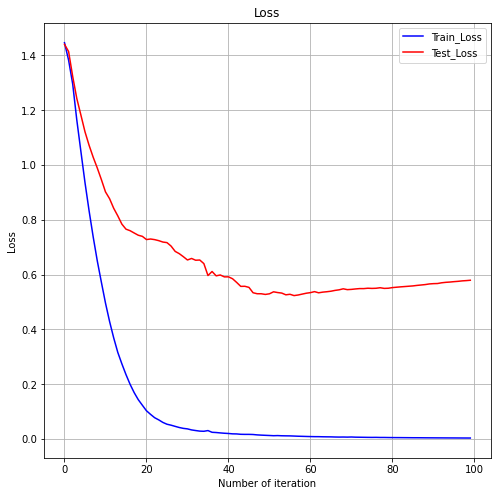


	 Training Loss: 0.0036  Testing Loss: 0.5795


In [5]:
plt.figure(figsize=(8,8))
plt.plot(col_train_j,'b-')
plt.plot(col_test_j,'r-')
plt.title('Loss')
plt.legend(['Train_Loss','Test_Loss'])
plt.ylabel('Loss')
plt.xlabel('Number of iteration')

plt.grid()
plt.show()

print()
print('\t Training Loss: %.4f  Testing Loss: %.4f' % (col_train_j[-1], col_test_j[-1]))


#### 5. Plot the accuracy curve

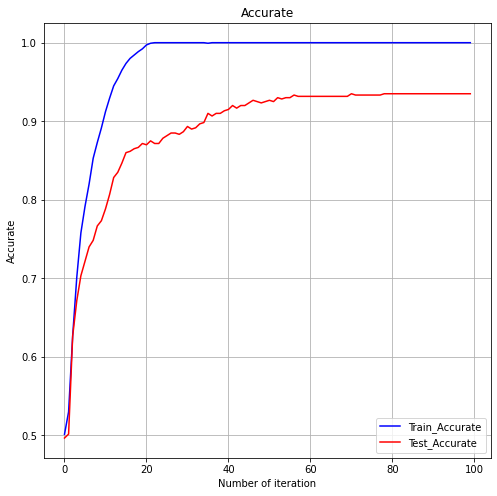


	 Training Accurate: 1.0000  Testing Accurate: 0.9350


In [6]:
plt.figure(figsize=(8,8))
plt.plot(col_train_acc,'b-')
plt.plot(col_test_acc,'r-')
plt.grid()
plt.title('Accurate')
plt.legend(['Train_Accurate','Test_Accurate'])
plt.ylabel('Accurate')
plt.xlabel('Number of iteration')

plt.show()

print()
print('\t Training Accurate: %.4f  Testing Accurate: %.4f' % (col_train_acc[-1], col_test_acc[-1]))


#### 5. Plot the training confusion matrix

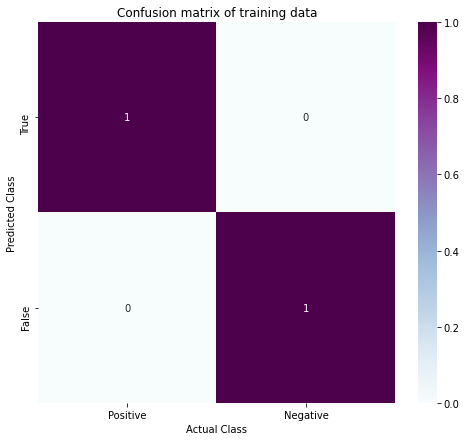

In [7]:
count_tp = 0
count_tn = 0
count_fp = 0
count_fn = 0

for rand_int in range(1400):

    input_v = np.append(X_train[rand_int],1)
    input_v = np.reshape(input_v, (-1, len(input_v)))
    
    actual_l = np.zeros(oput_len)
    actual_l[Y_train[rand_int]] = 1
    
    y_ = input_v.dot(u)
    y = sigmoid(y_)
    y = np.reshape(np.append(y, 1), (-1, len(np.append(y,1))))
    
    z_ = y.dot(v)
    z = sigmoid(z_)
    z = np.reshape(np.append(z, 1), (-1, len(np.append(z,1))))
    
    h_ = z.dot(w)
    h = sigmoid(h_) 
    
    output_l = np.zeros(oput_len)
    output_l[np.argmax(h)] = 1
    
    dE_dh = actual_l - output_l
      
    if Y_train[rand_int] == 1 and np.sum(dE_dh**2) == 0: count_tp += 1
    if Y_train[rand_int] == 1 and np.sum(dE_dh**2) != 0: count_fp += 1
    if Y_train[rand_int] == 0 and np.sum(dE_dh**2) == 0: count_tn += 1
    if Y_train[rand_int] == 0 and np.sum(dE_dh**2) != 0: count_fn += 1

precision_tp = count_tp/(count_tp + count_fp)
precision_tn = count_tn/(count_tn + count_fn)
precision_fp = count_fp/(count_fp + count_tp)
precision_fn = count_fn/(count_fn + count_tn)

array = [[precision_tp,precision_fp],[precision_fn,precision_tn]]
df_cm = pd.DataFrame(array, ['True','False'], ['Positive','Negative'])

plt.figure(figsize = (8,7))
plt.title('Confusion matrix of training data')
sn.heatmap(df_cm, cmap="BuPu", annot=True)
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')
plt.show()

#### 6. Plot the testing confusion matrix


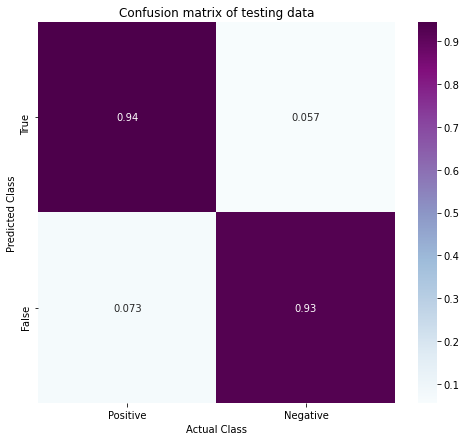

In [8]:
count_tp = 0
count_tn = 0
count_fp = 0
count_fn = 0

for rand_int in range(600):

    input_v = np.append(X_test[rand_int],1)
    input_v = np.reshape(input_v, (-1, len(input_v)))
    
    actual_l = np.zeros(oput_len)
    actual_l[Y_test[rand_int]] = 1
    
    y_ = input_v.dot(u)
    y = sigmoid(y_)
    y = np.reshape(np.append(y, 1), (-1, len(np.append(y,1))))
    
    z_ = y.dot(v)
    z = sigmoid(z_)
    z = np.reshape(np.append(z, 1), (-1, len(np.append(z,1))))
    
    h_ = z.dot(w)
    h = sigmoid(h_) 
    
    output_l = np.zeros(oput_len)
    output_l[np.argmax(h)] = 1
    
    dE_dh = actual_l - output_l
      
    if Y_test[rand_int] == 1 and np.sum(dE_dh**2) == 0: count_tp += 1
    if Y_test[rand_int] == 1 and np.sum(dE_dh**2) != 0: count_fp += 1
    if Y_test[rand_int] == 0 and np.sum(dE_dh**2) == 0: count_tn += 1
    if Y_test[rand_int] == 0 and np.sum(dE_dh**2) != 0: count_fn += 1

precision_tp = count_tp/(count_tp + count_fp)
precision_tn = count_tn/(count_tn + count_fn)
precision_fp = count_fp/(count_fp + count_tp)
precision_fn = count_fn/(count_fn + count_tn)

array = [[precision_tp,precision_fp],[precision_fn,precision_tn]]

df_cm = pd.DataFrame(array, ['True','False'], ['Positive','Negative'])

plt.figure(figsize = (8,7))
plt.title('Confusion matrix of testing data')
sn.heatmap(df_cm, cmap="BuPu", annot=True)
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')
plt.show()

#### 7. Final result

##### Training accuracy: $100 \%$ 
##### Testing accuracy: $93 \%$